<div style="text-align: left; background-color:#E9F7EF; font-family:Arial; color:#526085; padding: 12px; line-height:1.25;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 58px;border-style: solid;border-color: dark green;">Lab 05 - Support Vector Machine</div>
<div style="text-align: left; background-color:#fadefc; font-family: Arial; color:#551184; padding: 12px; line-height:1.25;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 18px">| LẠI TOÀN THẮNG - 20280083 - CA 2|</div>


> Description churn_rate_prediction.csv
-	Apply all knowledge and techniques that you have learned for this
-	You must organize your notebook based on the Homework
-	Should not drop NA and missing value


In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(color_codes=True)
%matplotlib inline


# **Load Dataset**

In [2]:
df = pd.read_csv("C:\\Users\\laito\\OneDrive - VNU-HCMUS\\Jupyter Hub\\KHDL\\KHDL-MACHINE LEARNING\\Labs\\Week 06\\Churn-Rate-Prediction\\churn_rate_prediction.csv")
df.head()

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,fffe4300490044003600300030003800,Pattie Morrisey,18,F,XW0DQ7H,Village,Platinum Membership,2017-08-17,No,xxxxxxxx,...,300.63,53005.25,17.0,781.75,Yes,Yes,No,Not Applicable,Products always in Stock,2
1,fffe43004900440032003100300035003700,Traci Peery,32,F,5K0N3X1,City,Premium Membership,2017-08-28,?,CID21329,...,306.34,12838.38,10.0,NaN,Yes,No,Yes,Solved,Quality Customer Care,1
2,fffe4300490044003100390032003600,Merideth Mcmeen,44,F,1F2TCL3,Town,No Membership,2016-11-11,Yes,CID12313,...,516.16,21027.00,22.0,500.69,No,Yes,Yes,Solved in Follow-up,Poor Website,5
3,fffe43004900440036003000330031003600,Eufemia Cardwell,37,M,VJGJ33N,City,No Membership,2016-10-29,Yes,CID3793,...,53.27,25239.56,6.0,567.66,No,Yes,Yes,Unsolved,Poor Website,5
4,fffe43004900440031003900350030003600,Meghan Kosak,31,F,SVZXCWB,City,No Membership,2017-09-12,No,xxxxxxxx,...,113.13,24483.66,16.0,663.06,No,Yes,Yes,Solved,Poor Website,5


# **Data Analysis**
> Analyze and Preprocess data - Check if the dataset has missing values or has any other problem.

In [3]:
df.dtypes

customer_id                      object
Name                             object
age                               int64
gender                           object
security_no                      object
region_category                  object
membership_category              object
joining_date                     object
joined_through_referral          object
referral_id                      object
preferred_offer_types            object
medium_of_operation              object
internet_option                  object
last_visit_time                  object
days_since_last_login             int64
avg_time_spent                  float64
avg_transaction_value           float64
avg_frequency_login_days         object
points_in_wallet                float64
used_special_discount            object
offer_application_preference     object
past_complaint                   object
complaint_status                 object
feedback                         object
churn_risk_score                  int64


In [4]:
# from pandas_profiling import ProfileReport
# ProfileReport(df)

> Note: 
* According to Profile Report, some features has missing values as below
	* `region_category` has `5428` missing values - use `mode imputation`
	* `preferred_offer_types` has `288` missing values - `Handle: drop rows with nan`
	* `points_in_wallet` has `3443` missing value and high correlation - `mean imputation`
* Beside that, còn một số ô mang dữ liệu không ý nghĩa như some cells have meaningless data
	* `joined_through_referral` values (?)
	* `referral_id` (17846  values xxxxxxxx), 
	* `medium_of_operation` (?)
	* `avg_frequency_login_days` has value is 3522 `Error` and `imbalance`
	* `age` has data type like Unknown

# **Data Preprocessing**

In [5]:
df["churn_risk_score"].value_counts()

churn_risk_score
 3    10424
 4    10185
 5     9827
 2     2741
 1     2652
-1     1163
Name: count, dtype: int64

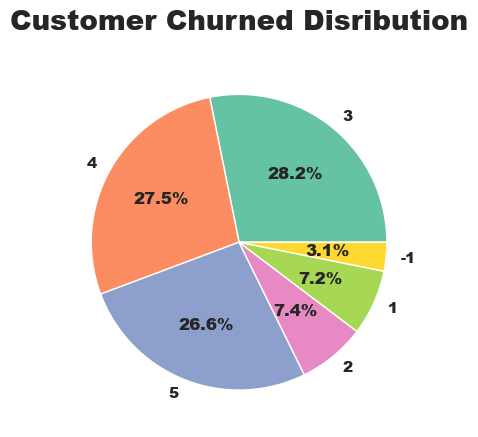

In [6]:
count = df["churn_risk_score"].value_counts()

plt.pie(count.values, labels=count.index, autopct="%1.1f%%",colors=sns.set_palette("Set2"),
        textprops={"fontweight":"black"})
plt.title("Customer Churned Disribution",fontweight="black",size=20,pad=20)
plt.show()

</div><div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<h3 align="left"><font color=brown>📊 Inference:</font></h3>

* There is **huge class-imbalance** which can lead to **bias in model performance.**
* So to **overcome** this **class-imbalance** we have to use **over-sampling technique** from **SMOTE**.

What is negative churn?

https://www.paddle.com/resources/negative-churn

Give u an example like this. Let's say you are running a software company that offers a subscription plan for 100$/month. At the beginning of the month, you have 100 customers and $10,000 revenue.

Throughout the month, know customer churn. 5 customers leave and cancel their subscriptions, resulting in a loss of $500. However, 10 existing customer upgrade their plans and you receive $1000

This represents growth from your existing customers and contributes to overall revenue expansion without acquiring new customers.

In this dataset, what is the reason?
> There is a huge difference between some of the classes in the target(churn_risk_score) column.(-1,1 and 2 are quite less as compared 3,4,5). We will handle it when creating the model

In [7]:
print('Total', df.shape[0], 'samples')
df.isnull().sum().to_frame().rename(columns={0:"Total No. of Missing Values"})

Total 36992 samples


,Total No. of Missing Values
customer_id,0
Name,0
age,0
gender,0
security_no,0
region_category,5428
membership_category,0
joining_date,0
joined_through_referral,0
referral_id,0


In [8]:
df[df.duplicated()]

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score


In [9]:
df.describe(include="object").T

,count,unique,top,freq
customer_id,36992,36992,fffe4300490044003600300030003800,1
Name,36992,36992,Pattie Morrisey,1
gender,36992,3,F,18490
security_no,36992,36992,XW0DQ7H,1
region_category,31564,3,Town,14128
membership_category,36992,6,Basic Membership,7724
joining_date,36992,1096,2015-06-02,55
joined_through_referral,36992,3,No,15839
referral_id,36992,11359,xxxxxxxx,17846
preferred_offer_types,36704,3,Gift Vouchers/Coupons,12349


> Note: 
* Drop những cột feature không mang bất cứ insight nào để dự đoán churn risk như `customer_id`, `Name`, `security_no`, `joining_date`, `referral_id`, `last_visit_time`


In [10]:
print(df['gender'].value_counts())

gender
F          18490
M          18443
Unknown       59
Name: count, dtype: int64


In [11]:
from sklearn.impute import SimpleImputer
def preprocessing_data(df):
    """
    Preprocess your data (eg. Drop null datapoints or fill missing data)
    :param df: pandas DataFrame
    :return: pandas DataFrame
    """
    # Todo: preprocess data
    
    # Drop unnecessary column
    df = df.drop(columns=['customer_id', 'Name', 'security_no', 'referral_id', 'days_since_last_login', 'joining_date', 'last_visit_time'], axis = 1)
    
    df['avg_frequency_login_days'] = pd.to_numeric(df['avg_frequency_login_days'], errors='coerce')
    # df['churn_risk_score'] = df['churn_risk_score'].astype('category')
    
    # Fill nan in preferred_offer_types by 
    imputer_mode = SimpleImputer(strategy='most_frequent')
    df[['region_category']] = imputer_mode.fit_transform(df[['region_category']])
    df[['region_category']] = imputer_mode.fit_transform(df[['region_category']])
    df[['preferred_offer_types']] = imputer_mode.fit_transform(df[['preferred_offer_types']])
    
    # Fill nan by mean of points in wallet
    imputer_mean = SimpleImputer(strategy = 'mean')
    df[['points_in_wallet']] = imputer_mean.fit_transform(df[['points_in_wallet']])
    df[['avg_frequency_login_days']] = imputer_mean.fit_transform(df[['avg_frequency_login_days']])
    
    df['gender'] = df['gender'].replace({'Unknown': df['gender'].mode()[0]})
    
    return df

In [13]:
# no effect to the original data
df = preprocessing_data(df.copy())

joined_through_referral: join by invitation by friends or family



# **Exploratory Data Analysis**

In [14]:
categorical_cols = [feature for feature in df.columns if df[feature].dtype == 'O']
numerical_cols = [feature for feature in df.columns if df[feature].dtype != 'O']
outlier_columns = ['avg_time_spent','avg_transaction_value', 'avg_frequency_login_days', 'points_in_wallet']

In [16]:
print(categorical_cols)

['gender', 'region_category', 'membership_category', 'joined_through_referral', 'preferred_offer_types', 'medium_of_operation', 'internet_option', 'avg_frequency_login_days', 'used_special_discount', 'offer_application_preference', 'past_complaint', 'complaint_status', 'feedback']


In [17]:
print(numerical_cols)

['age', 'avg_time_spent', 'avg_transaction_value', 'points_in_wallet', 'churn_risk_score']


In [ ]:
fig, axes = plt.subplots(len(categorical_cols), 1 , figsize = (20, 3 * len(categorical_cols)), sharex = False, sharey = False)
for i, column in enumerate(categorical_cols):
  ax = sns.countplot(x=column, data=df, ax=axes[i], hue="churn_risk_score", palette="Set2")
  for value in ax.patches:
        percentage = "{:.1f}%".format(100*value.get_height()/len(df[column]))
        x = value.get_x() + value.get_width() / 2 - 0.05
        y = value.get_y() + value.get_height()
        ax.annotate(percentage, (x,y), fontweight="black",size=10)
plt.tight_layout(pad=1.5)
plt.show()

* Membership: The ratio of customers have no membership or low membership, will have a low churn rate score 
* joined_through_referral: what is `?`. Maybe they found it by coincidence and stick to using it

TypeError: Horizontal orientation requires numeric `x` variable.

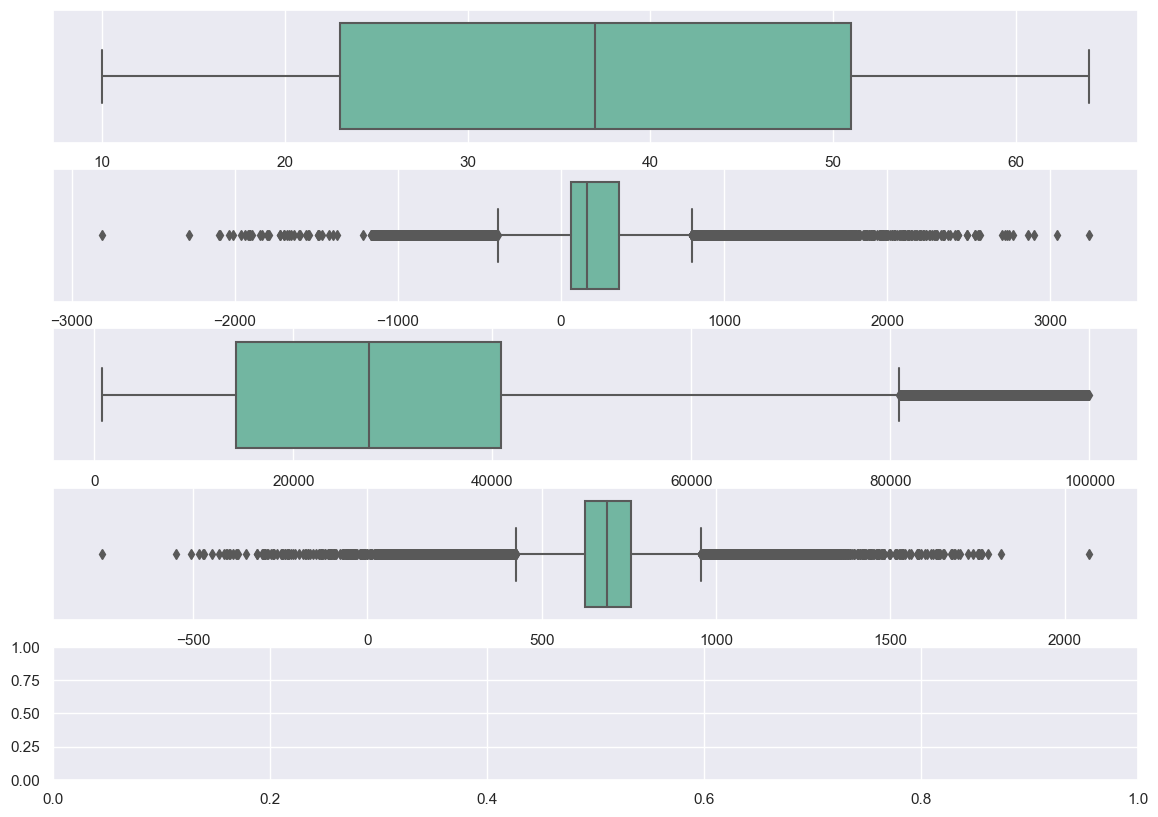

In [18]:
fig, axes=plt.subplots(len(numerical_cols), 1, figsize=(14, 2*len(numerical_cols)),sharex=False,sharey=False)

for i, column in enumerate(numerical_cols):
    sns.boxplot(x=column,data=df,palette='Set2',ax=axes[i])
plt.tight_layout(pad=2.0)

> Why so many negative numbers in features which is average of time. It will be make sense if the number more than 0. Damnn

In [ ]:
# Handle outlier
outlier_columns = ['avg_time_spent','avg_frequency_login_days','points_in_wallet']
for col in outlier_columns:
    lower_limit, upper_limit = df[col].quantile([0.25,0.75])
    IQR = upper_limit - lower_limit
    lower_whisker = lower_limit - 1.5 * IQR
    upper_whisker = upper_limit + 1.5 * IQR
    df[col] = np.where(df[col]<lower_whisker,lower_whisker,np.where(df[col]>upper_whisker,upper_whisker,df[col]))

In [ ]:
def numerical_plot(column, df):
    plt.figure(figsize=(13,6))
    plt.subplot(1,2,1)
    # sns.histplot(data = df, x = column, hue = 'churn_risk_score', kde = True, palette = 'Set2')
    sns.kdeplot(data = df, x = column, hue = 'churn_risk_score', palette='Set2', shade = True)
    plt.title(f"Distribution of {column} by Churn Status",fontweight="black",pad=20,size=11)
    
    plt.subplot(1,2,2)
    sns.boxenplot(data = df, x = column)
    plt.title(f"Distribution of {column} by Churn Status",fontweight="black",pad=20,size=11)
    plt.tight_layout()
    plt.show()

C:\Users\laito\AppData\Local\Temp\ipykernel_3384\1807629984.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data = df, x = column, hue = 'churn_risk_score', palette='Set2', shade = True)


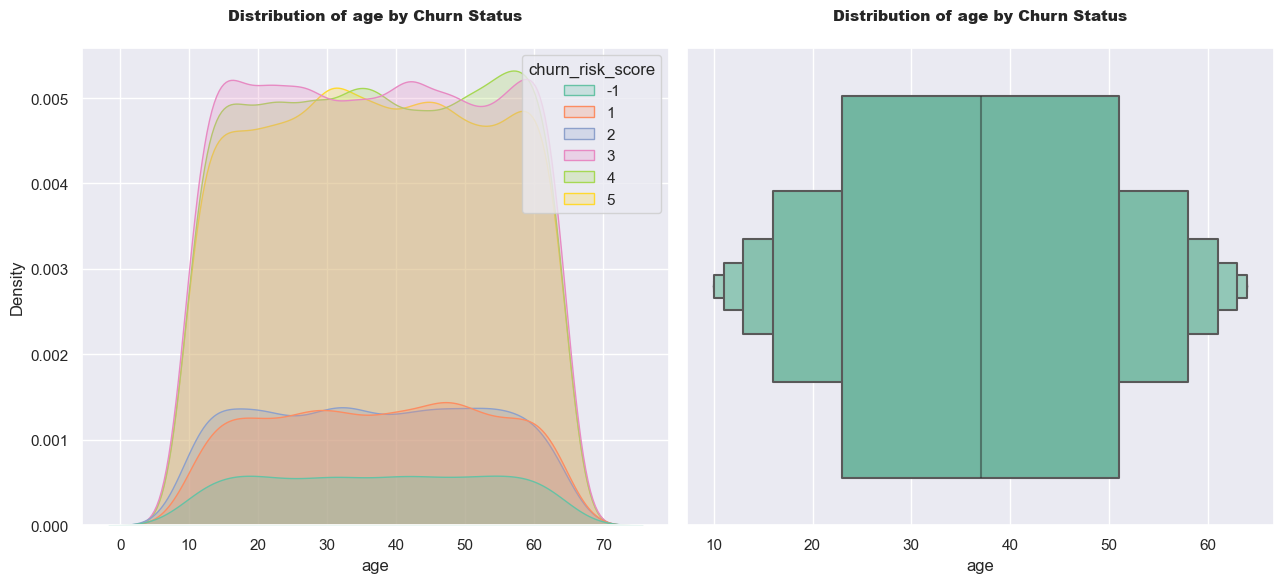

C:\Users\laito\AppData\Local\Temp\ipykernel_3384\1807629984.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data = df, x = column, hue = 'churn_risk_score', palette='Set2', shade = True)


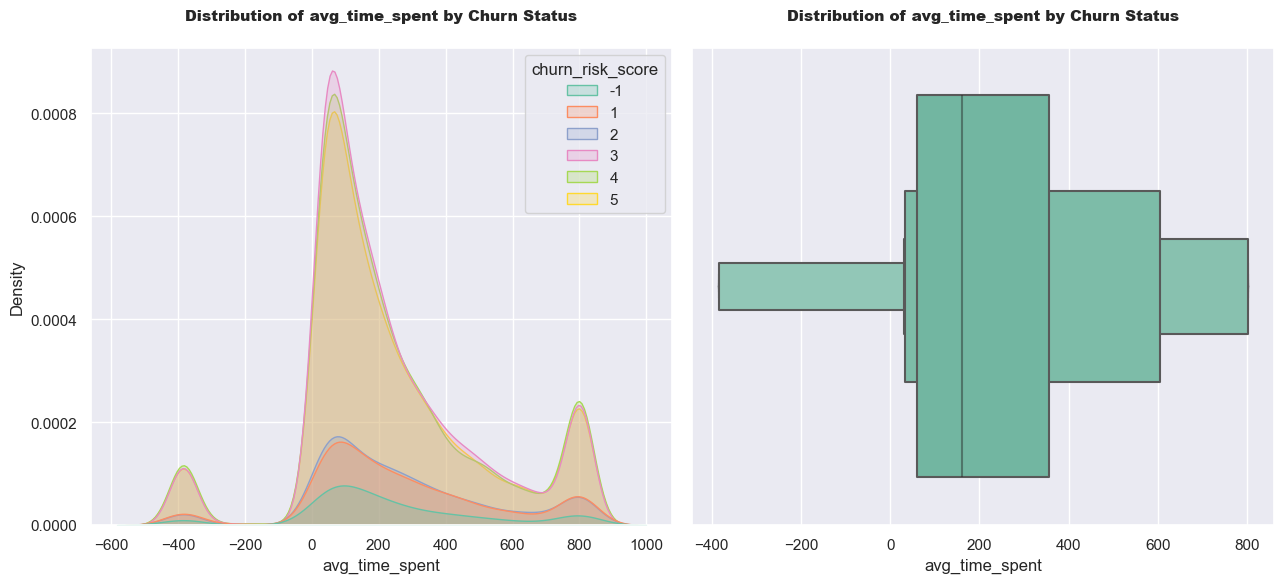

C:\Users\laito\AppData\Local\Temp\ipykernel_3384\1807629984.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data = df, x = column, hue = 'churn_risk_score', palette='Set2', shade = True)


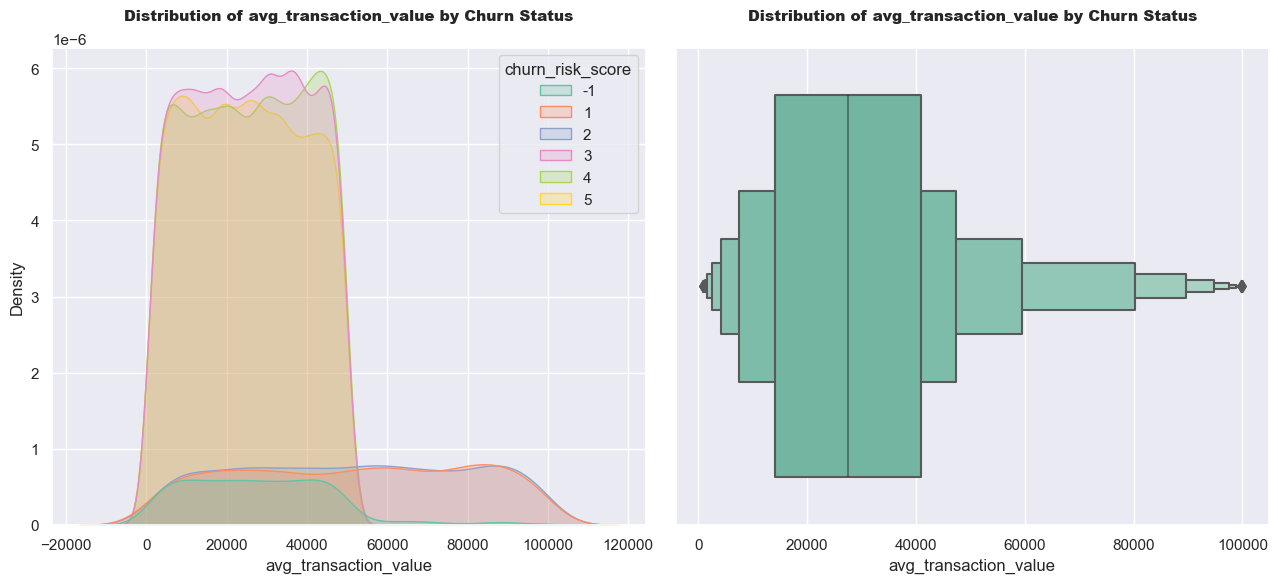

C:\Users\laito\AppData\Local\Temp\ipykernel_3384\1807629984.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data = df, x = column, hue = 'churn_risk_score', palette='Set2', shade = True)


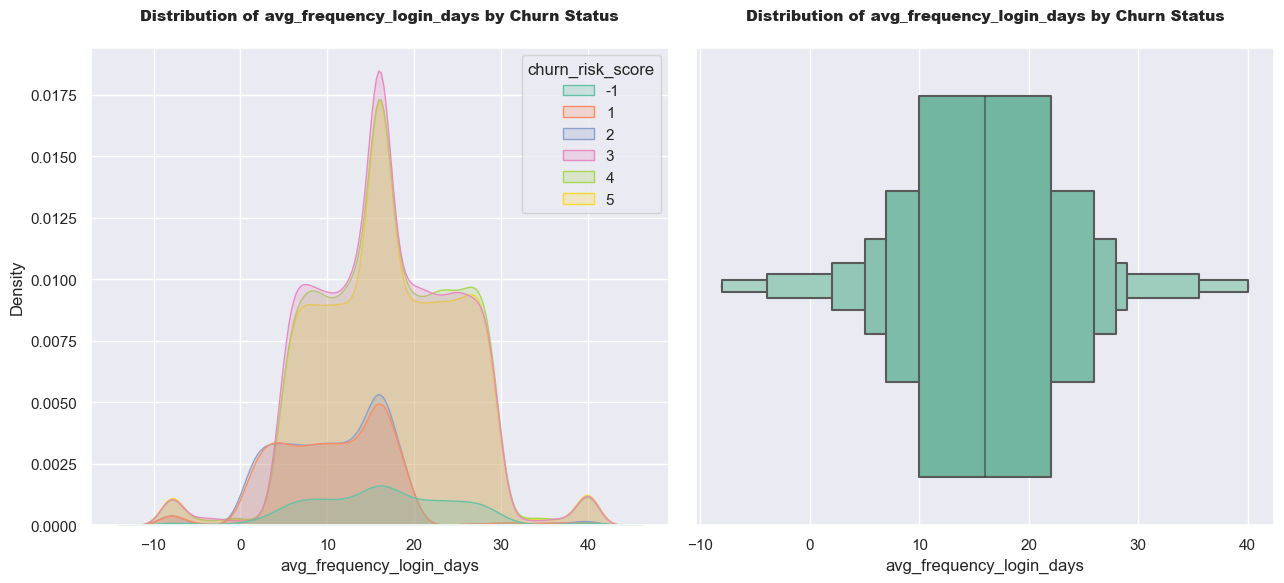

C:\Users\laito\AppData\Local\Temp\ipykernel_3384\1807629984.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data = df, x = column, hue = 'churn_risk_score', palette='Set2', shade = True)


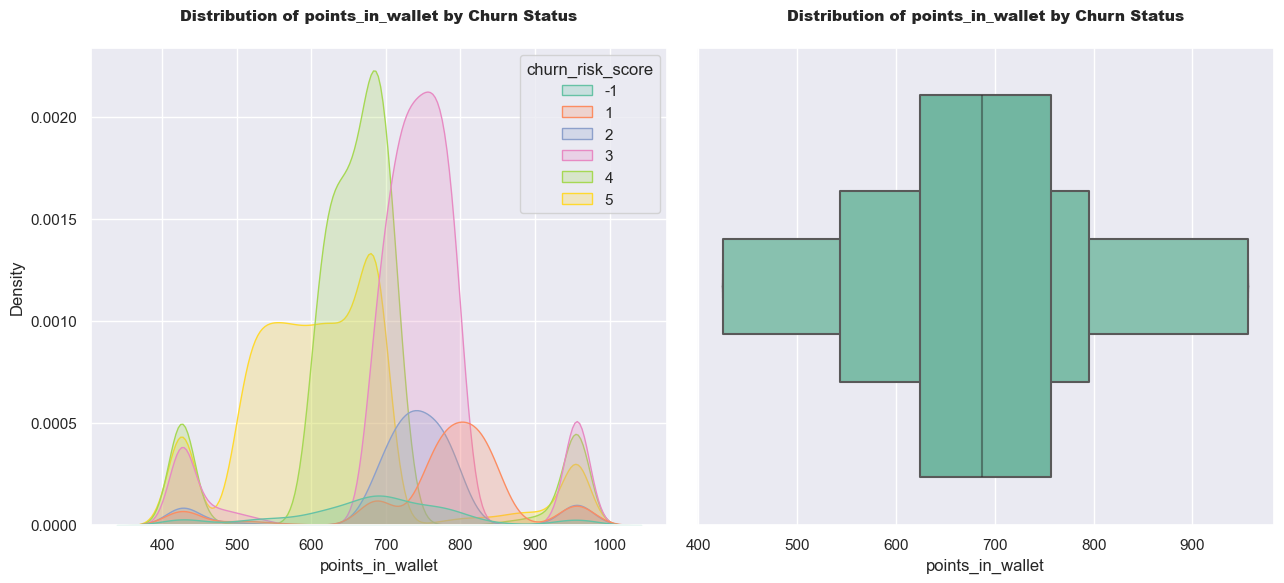

<Figure size 640x480 with 0 Axes>

In [ ]:
for column in numerical_cols[:-1]:
  numerical_plot(column, df)
plt.tight_layout(pad=1.0)

> As we can see in the previous figures, lines 3, 4, and 5 have a higher density than others. Then we replace those churn risk score which has values [3, 4, 5] with yes and the others turn into 0, 1, 2

In [ ]:
# df['churn_risk_score'] = df['churn_risk_score'].replace({-1: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1})

In [ ]:
print(Counter(df['churn_risk_score']))

Counter({3: 10424, 4: 10185, 5: 9827, 2: 2741, 1: 2652, -1: 1163})


In [ ]:
# 
df.complaint_status.replace(['Solved','Solved in Follow-up'],'Solved',inplace=True)
df.complaint_status.replace(['Not Applicable','No Information Available'],'Unknown',inplace=True)
df.complaint_status.replace(['Unknown','Solved','Unsolved'],[-1,1,0],inplace=True)
df.complaint_status = df.complaint_status.astype(int)

In [ ]:
df.feedback.replace(['Poor Product Quality','Too many ads','Poor Website','Poor Customer Service'],-1,inplace=True)
df.feedback.replace(['Reasonable Price','User Friendly Website','Products always in Stock','Quality Customer Care'],1,inplace=True)
df.feedback.replace('No reason specified',0,inplace=True)
df.feedback = df.feedback.astype(int)

In [ ]:
df.offer_application_preference.replace(['Yes','No'],[1,0],inplace=True)
df.offer_application_preference = df.offer_application_preference.astype(int)
df.past_complaint.replace(['Yes','No'],[1,0],inplace=True)
df.past_complaint = df.past_complaint.astype(int)
df.joined_through_referral.replace(['No','Yes','?'],[0,1,-1],inplace=True)
df.joined_through_referral = df.joined_through_referral.astype(int)
df.used_special_discount.replace(['Yes','No'],[1,0],inplace=True)
df.used_special_discount = df.used_special_discount.astype(int)

# **Data Visualization**

In [ ]:
# plt.figure(figsize=(12,8),dpi=200)
# sns.lineplot(x='age',y='avg_transaction_value',data=df,hue='churn_risk_score')
# plt.legend(bbox_to_anchor=(1.2,0.5),title="Churn Risk Score")

In [ ]:
# ax = sns.catplot(x='membership_category',y='avg_transaction_value',data=df,hue='churn_risk_score',col='region_category',kind='bar',height=5,aspect=1)

# for g in ax.axes:
#     ax.set_xticklabels(rotation=90)

It is clearly evident that the customers having Platinum and Premium membership have realistically no chance of churn. They are almost certain to stay for long term. Moreover, customers possessing Platinum and Premier membership have significant average transaction values.

In [ ]:
# ax = sns.catplot(x='membership_category',y='avg_time_spent',data=df,hue='churn_risk_score',col='region_category',kind='bar',height=5,aspect=1,palette='plasma')

# for g in ax.axes:
#     ax.set_xticklabels(rotation=90)

Among the customers residing in villages who are unlikely to churn, the ones with basic membership spend the maximum amount of time on the company's online apps and websites whereas those with platinum membership expend the least.

In [ ]:
# ax = sns.catplot(x='preferred_offer_types',y='avg_time_spent',data=df,hue='churn_risk_score',col='region_category',kind='bar',height=5,aspect=1,palette='plasma')

# for g in ax.axes:
#     ax.set_xticklabels(rotation=90)

# **Feature Engineering**

In [ ]:
def convert_categorical_to_numerical(df, col):
  df[col] = df[col].astype("category").cat.codes
  
def apply_feature_engineering(df):
    # Todo: Normalize your data
    for feature in categorical_cols:
        convert_categorical_to_numerical(df, feature)
        
    # Handle outlier
    df = df[df['avg_time_spent']>0]
    return df


df = apply_feature_engineering(df)


<AxesSubplot:>

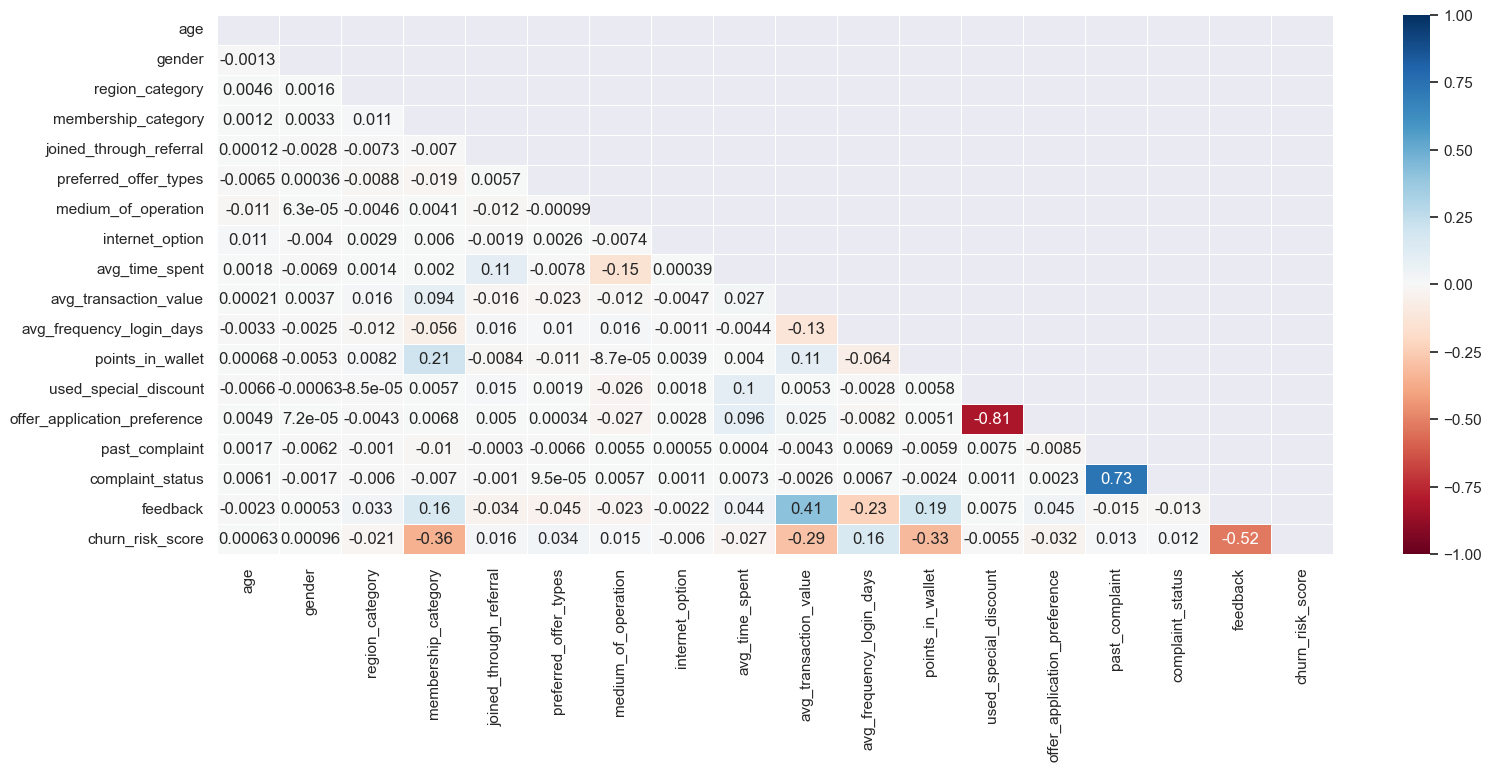

In [ ]:
# Show heatmap after normalized data
corr = df.corr()
plt.figure(figsize = (18, 7))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr,mask=mask,cmap='RdBu', vmin=-1, vmax= 1 , center=0, annot=True,linewidth=0.5)

<AxesSubplot:title={'center':'Correlation Between Target based on All Features'}>

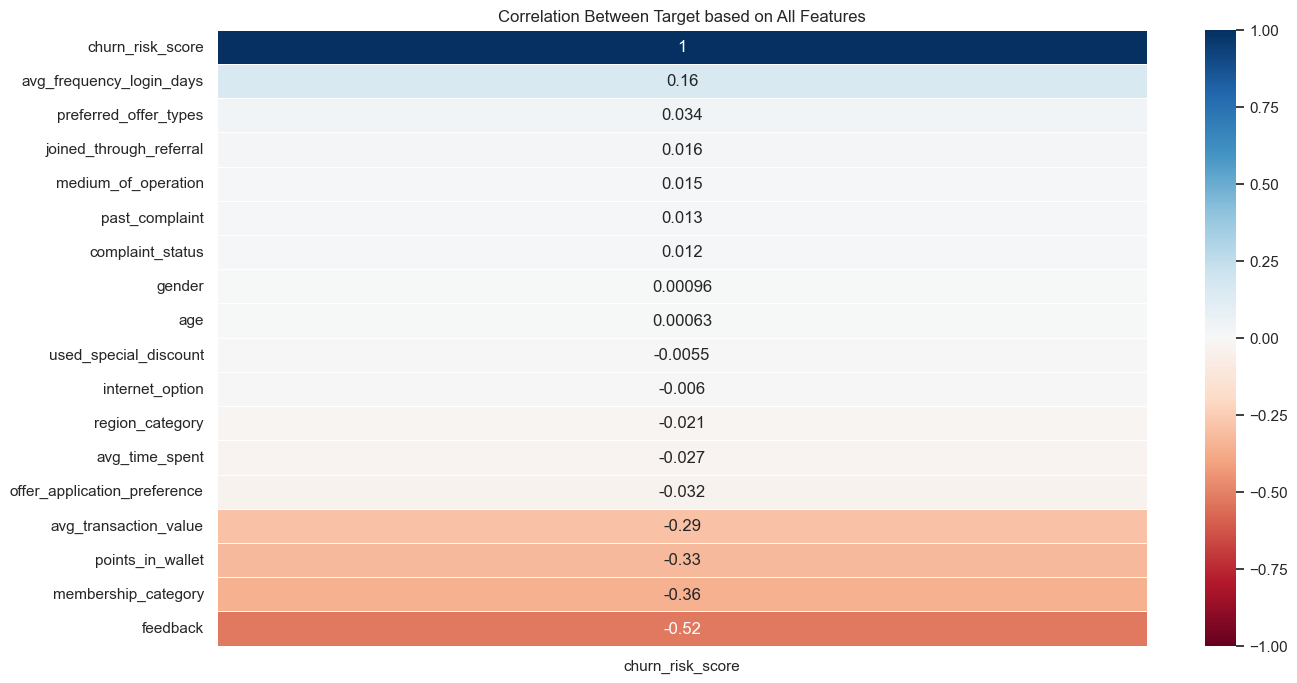

In [ ]:
plt.figure(figsize=(15,8))
plt.title('Correlation Between Target based on All Features')
sns.heatmap(df.corr()[['churn_risk_score']].sort_values(by='churn_risk_score', ascending=False),cmap='RdBu', vmin=-1, vmax= 1 , center=0, annot=True,linewidth=.5,square=False)

In [ ]:
# One Hot Encoding on Categorical Features
# dummy_col = ['region_category', 'membership_category','preferred_offer_types', 'medium_of_operation', 'internet_option']
df = pd.get_dummies(columns=categorical_cols, data=df)
# for col in dummy_col:
#     print(col,':')
#     encoder = LabelEncoder()
#     df[col] = encoder.fit_transform(df[col])
#     df[col] = df[col].astype(int)
#     print(encoder.classes_, encoder.transform(encoder.classes_))

In [ ]:
# Checking skewness of numerical features
df[numerical_cols].skew().to_frame().rename(columns={0:"Feature Skewness"})

,Feature Skewness
age,-0.008628
avg_time_spent,1.117138
avg_transaction_value,1.014139
avg_frequency_login_days,0.050146
points_in_wallet,-0.033917
churn_risk_score,-1.111172


<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<h3 align="left"><font>📊 Note:</font></h3>

    
* `avg_transaction_value` is highly right-skewed, which conveys that there is presence of **positive outliers**
* The same thing comes to `avg_time_spent`

In [ ]:
avg_time_spent_save = df['avg_time_spent']
avg_transaction_value_save = df['avg_transaction_value']

In [ ]:
df['avg_transaction_value'] = np.log(df['avg_transaction_value'])

In [ ]:
df.isnull().sum()

age                               0
avg_time_spent                    0
avg_transaction_value             0
avg_frequency_login_days          0
points_in_wallet                  0
churn_risk_score                  0
gender_0                          0
gender_1                          0
region_category_0                 0
region_category_1                 0
region_category_2                 0
membership_category_0             0
membership_category_1             0
membership_category_2             0
membership_category_3             0
membership_category_4             0
membership_category_5             0
joined_through_referral_0         0
joined_through_referral_1         0
joined_through_referral_2         0
preferred_offer_types_0           0
preferred_offer_types_1           0
preferred_offer_types_2           0
medium_of_operation_0             0
medium_of_operation_1             0
medium_of_operation_2             0
medium_of_operation_3             0
internet_option_0           

## **Visualizing Transformation.**

In [ ]:
plt.figure(figsize=(13,6))
plt.subplot(1,2,1)
sns.histplot(avg_transaction_value_save, color="purple", kde=True)
plt.title("Before Transformation",fontweight="black",size=18,pad=20)

plt.subplot(1,2,2)
sns.histplot(df['avg_transaction_value'], color="purple", kde=True)
plt.title("After Transformation",fontweight="black",size=18,pad=20)
plt.tight_layout()
plt.show()

# **Model Training**

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# build model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import GridSearchCV

# Dimentional Reduction
from sklearn. decomposition import PCA

# build pipeline
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, accuracy_score, recall_score, precision_score

import warnings
warnings.filterwarnings('ignore')

In [ ]:
def prepare_X_y(df):
    X = df.drop('churn_risk_score', axis = 1)
    y = df['churn_risk_score']
    return X, y

X, y = prepare_X_y(df)

In [ ]:
RANDOM_STATE = 7
TRAIN_SIZE = 0.7

X_train, X_test ,y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)

> Built a Predictive Model to find the key factors that are significantly influencing customers churn rate score

## *Sampling Data*

In [ ]:
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
# # Define the model
# model = DecisionTreeClassifier()

# # Define the different sampling techniques
# samplers = {
#     'Random Oversampling': RandomOverSampler(),
#     'SMOTE': SMOTE(),
#     'Random Undersampling': RandomUnderSampler()
# }

# # Perform cross-validation and evaluate the accuracy for each sampling technique
# for sampler_name, sampler in samplers.items():
#     X_resampled, y_resampled = sampler.fit_resample(X, y)
#     scores = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='accuracy')
#     print(f"{sampler_name}: Accuracy = {scores.mean():.4f}")
    
# Random Oversampling: Accuracy = 0.8702
# SMOTE: Accuracy = 0.7837
# Random Undersampling: Accuracy = 0.5394

> Churn risk score is imbalance, so I use smote to make it balance

In [ ]:
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
# scaler = StandardScaler()
# features = X_train_resampled.columns
# X_train_resampled = scaler.fit_transform(X_train_resampled.values)
# X_train_resampled = pd.DataFrame(X_train_resampled,columns=features)
# X_train_resampled.head()

In [ ]:
# from sklearn import svm
# svm = svm.SVC()
# svm.fit(X_train_resampled,y_train_resampled)

In [ ]:
# svm_pred = svm.predict(X_test)
# print(classification_report(y_test,svm_pred))


In [ ]:
# scalers = [MinMaxScaler(), RobustScaler(), StandardScaler()]
# n_components = [2, 3]

# pipelines = [
#     make_pipeline(scaler, PCA(n_components=n_component))
#     for scaler in scalers
#     for n_component in n_components
# ]

# def build_pipeline(df, pipelines):    
#     for pipeline, n_component in zip(pipelines, n_components * len(scalers)):
#         print(pipeline, n_component)
#     pca_dfs = [
#         pd.DataFrame(data=pipeline.fit_transform(df), columns=[f"pca{i+1}" for i in range(n_component)])
#         for pipeline, n_component in zip(pipelines, n_components*len(scalers))
#     ]        
#     return pca_dfs


In [ ]:
# print(cross_val_score(DecisionTreeClassifier(), X_train_resampled, y_train_resampled, cv = 5, scoring = 'accuracy').mean())

In [ ]:
# dt_model = DecisionTreeClassifier()
# dt_model.fit(X_train_resampled, y_train_resampled)
# predictdt_y = dt_model.predict(X_test)
# accuracy_dt = dt_model.score(X_test, y_test)
# print("Decision Tree accuracy is :",accuracy_dt)
# print(classification_report(y_test, predictdt_y))

# # Decision Tree accuracy is : 0.9349432330149576
# #               precision    recall  f1-score   support

# #            0       0.80      0.86      0.83      2022
# #            1       0.97      0.95      0.96      9076

# #     accuracy                           0.93     11098
# #    macro avg       0.88      0.91      0.89     11098
# # weighted avg       0.94      0.93      0.94     11098

In [ ]:
# # Parameter grid
# param_grid = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [None, 5, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt', 'log2', None]
# }

# # Create the DecisionTreeClassifier
# classifier = DecisionTreeClassifier()

# # Perform grid search
# grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train_resampled, y_train_resampled)

# # Print the best parameters and best score
# print("Best Parameters: ", grid_search.best_params_)
# print("Best Score: ", grid_search.best_score_)

# # # Best Parameters:  {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
# # # Best Score:  0.9773174157303369

In [ ]:
# # Creating DecisionTree Model Using Best Parameters.
# best_parameters = grid_search.best_params_
# dtree = DecisionTreeClassifier(**best_parameters)

# dtree.fit(X_train_resampled, y_train_resampled)

In [ ]:
# # Computing Model Accuracy.
# y_train_pred = dtree.predict(X_train_resampled)
# y_test_pred = dtree.predict(X_test)

# print("Accuracy Score of Model on Training Data is =>",round(accuracy_score(y_train_resampled,y_train_pred)*100,2),"%")
# print("Accuracy Score of Model on Testing Data  is =>",round(accuracy_score(y_test,y_test_pred)*100,2),"%")

In [ ]:
# # Model Evaluation using Different Metric Values.
# print("F1 Score of the Model is =>",f1_score(y_test,y_test_pred,average="micro"))
# print("Recall Score of the Model is =>",recall_score(y_test,y_test_pred,average="micro"))
# print("Precision Score of the Model is =>",precision_score(y_test,y_test_pred,average="micro"))

<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<h3 align="left"><font color=brown>📊 Note:</font></h3>

* We can observe that **recall, precision, and F1 score are all the same**, it means that our **model is achieving perfect balance between** correctly identifying **positive samples (recall)** and minimizing **false positives (precision).**

    
* The **high values** for **F1 score, recall score, and precision score**, all of which are **approximately 0.8.** These **metrics suggest** that the **model achieves good accuracy** in predicting the **positive class.**

In [ ]:
# imp_df = pd.DataFrame({"Feature Name":df.drop('churn_risk_score', axis = 1).columns,
#                       "Importance":dtree.feature_importances_})

In [ ]:
# features = imp_df.sort_values(by="Importance",ascending=False)

# plt.figure(figsize=(12,15))
# sns.barplot(x="Importance", y="Feature Name", data=features, palette="plasma")
# plt.title("Feature Importance in the Model Prediction", fontweight="black", size=20, pad=20)
# plt.yticks(size=12)
# plt.show()

In [ ]:
# cm = confusion_matrix(y_test,y_test_pred)

# plt.figure(figsize=(15,6))
# sns.heatmap(data=cm, linewidth=.5, annot=True, fmt="g", cmap="Set1")
# plt.title("Model Evaluation using Confusion Matrix",fontsize=20,pad=20,fontweight="black")
# plt.ylabel("Actual Labels")
# plt.xlabel("Predicted Labels")
# plt.show()

In [ ]:
from sklearn.svm import SVC
svc_model = SVC(random_state=1)
svc_model.fit(X_train_resampled, y_train_resampled)
predict_y = svc_model.predict(X_test)
accuracy_svc = svc_model.score(X_test, y_test)
print("SVM accuracy is :",accuracy_svc)
print(classification_report(y_test, predict_y))


# 2m 25s
# SVM accuracy is : 0.5331591277707695
#               precision    recall  f1-score   support

#           -1       0.00      0.00      0.00       341
#            1       0.00      0.00      0.00       839
#            2       0.00      0.00      0.00       842
#            3       0.51      0.81      0.63      3160
#            4       0.51      0.66      0.58      3004
#            5       0.62      0.48      0.54      2912

#     accuracy                           0.53     11098
#    macro avg       0.27      0.32      0.29     11098
# weighted avg       0.45      0.53      0.48     11098

KeyboardInterrupt: 

In [ ]:
# from sklearn import svm
# # Parameter grid
# param_grid = {
#     'C': [1],
#     'kernel': ['linear', 'sigmoid'],
#     'gamma': ['auto']
# }

# # Create the SVM classifier
# classifier = svm.SVC()

# # Perform grid search
# grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train_resampled, y_train_resampled)

# # Print the best parameters and best score
# print("Best Parameters: ", grid_search.best_params_)
# print("Best Score: ", grid_search.best_score_)

# # Creating SVM Model Using Best Parameters.
# best_parameters = grid_search.best_params_
# svm = SVC(**best_parameters)

# svm.fit(X_train_resampled, y_train_resampled)

# # Computing Model Accuracy.
# y_train_pred = svm.predict(X_train_resampled)
# y_test_pred = svm.predict(X_test)

# print("Accuracy Score of Model on Training Data is =>", round(accuracy_score(y_train_resampled, y_train_pred) * 100, 2), "%")
# print("Accuracy Score of Model on Testing Data  is =>", round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")

# # Model Evaluation using Different Metric Values.
# print("F1 Score of the Model is =>", f1_score(y_test, y_test_pred, average="micro"))
# print("Recall Score of the Model is =>", recall_score(y_test, y_test_pred, average="micro"))
# print("Precision Score of the Model is =>", precision_score(y_test, y_test_pred, average="micro"))